In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import quantumaudio as qa

In [5]:
#Reading the audio file
data,sample_rate = sf.read('ZachZubow_Nebulae.aif')
data = list(data[:32768,0])
N = len(data)

Text(0, 0.5, 'amplitude')

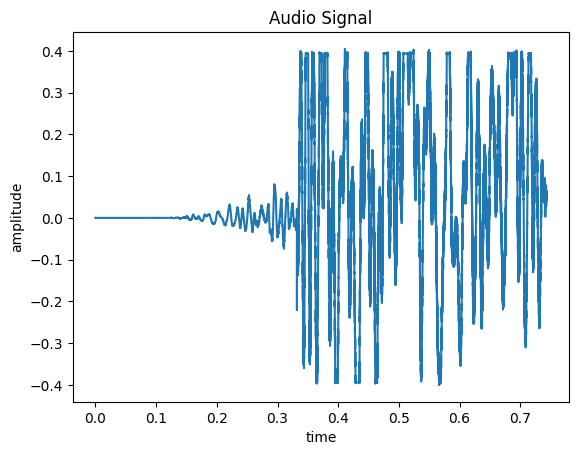

In [6]:
#Plotting the audio signal
time = np.arange(len(data))/sample_rate
plt.plot(time,data)
plt.title('Audio Signal')
plt.xlabel('time')
plt.ylabel('amplitude')

In [23]:
#Extending the data to make N=2**n where n is number of qubits used to encode the audio in a quantum circuit

n_qubits = math.ceil(np.log2(N))
data.extend([0] * (2**n_qubits-N))
data = data/np.linalg.norm(data)
print(n_qubits)

#Encoding the data array on the quantum circuit by using 'qpam' method - which takes the input data, normalizes it and initializes on circuit of n qubits
qsound_qpam = qa.QuantumAudio('qpam')
qsound_qpam.load_input(data)
qsound_qpam.prepare()
qc = qsound_qpam.circuit

15
For this input, the QPAM representation will require:
         15 qubits for encoding time information and 
         0 qubits for encoding ampĺitude information.


In [8]:
#Defining qft algorithm
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

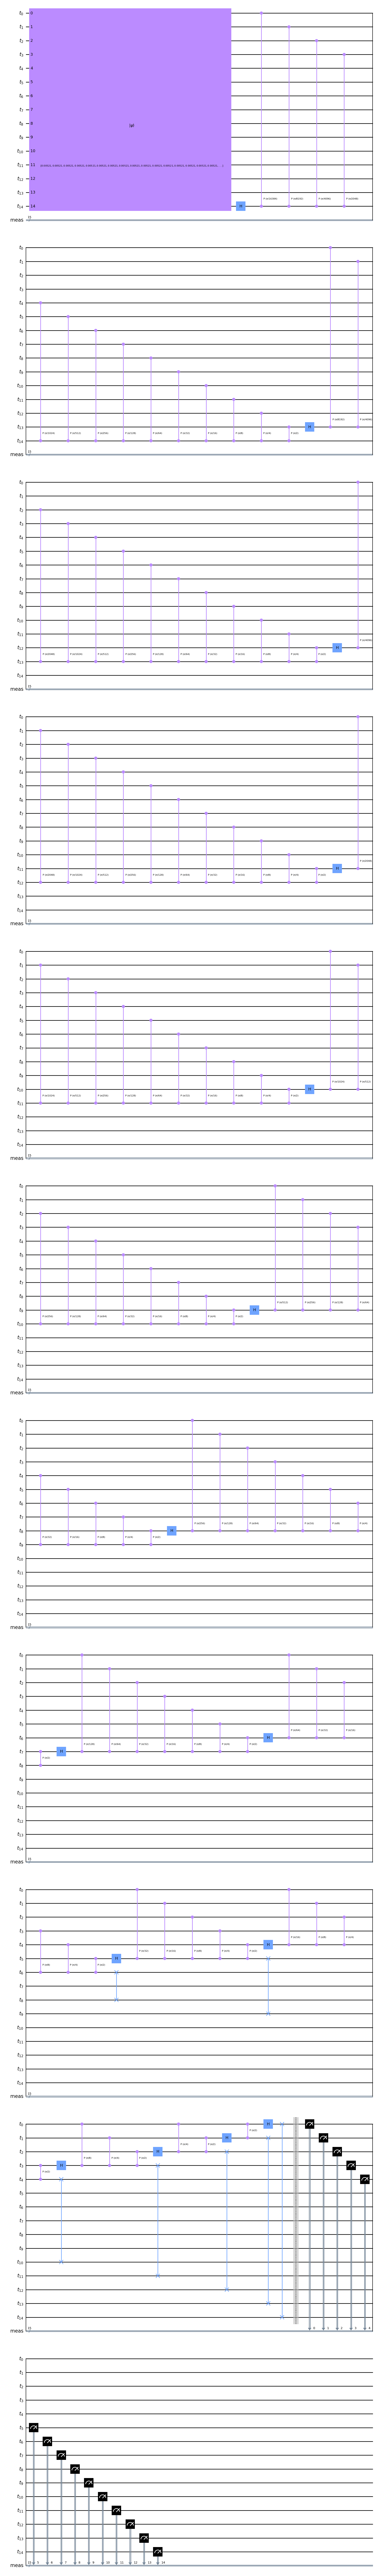

In [9]:
#Creating a circuit with quantum fourier transform alogithm
qft_circuit=qft(n_qubits)

#Merging both the initialized circuit and qft circuit
audio_qc = qc.compose(qft_circuit,list(np.arange(n_qubits)))

#Measuring the qubits to get the classical results
audio_qc.measure_all()
audio_qc.draw('mpl')

In [10]:
#Using my IBM Quantum Experience account to access the quantum simulator online
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Sampler, Session, Options

service = QiskitRuntimeService(
     channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='84e47768480771b0f65f16b3f25447e5ab6b88d174cccb8271d1d0a3e4fdf3ce875e7f9f2612ad64f6f107644f49d8c6d9cd2619469de103753b4ae7556e703a'
)
backend = service.backend('ibmq_qasm_simulator')

In [ ]:
#Executing the circuit in the chosen backend
options = Options()
options.execution.shots = 10000    #Since we get the results probabilistically, we choose it run the same circuit multiple times.
sampler = Sampler(options=options,backend=backend)
job = sampler.run(audio_qc)        #Submitting the job to the backend
result = job.result()              #Extracting the results from the job once it is executed successfully

In [11]:
#Calling the job executed above with its job_id
job = service.job('clo4lcj8gqkndhps1sqg')
result = job.result()

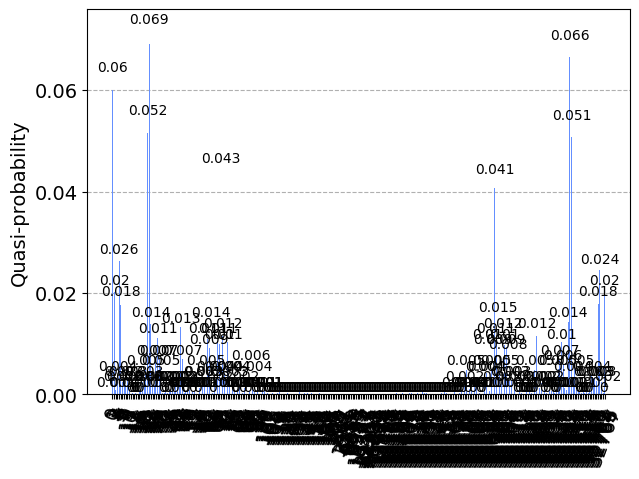

In [12]:
#plotting the probability histogram obtained (in this case this is the absolute value of fourier coefficients)
counts = result.quasi_dists
plot_histogram(counts)

In [13]:
#Defining the function to arange the counts got in ascending order and getting the corresponding probability (i.e., np.abs(fft)).
    
def get_fft_from_counts(counts,n_qubits):
    fft = []
    keys = counts.keys()
    for i in range(2**n_qubits):
        if i in keys:
            fft.append(counts[i])
        else:
            fft.append(0)
    return fft

In [14]:
qft = get_fft_from_counts(counts[0],n_qubits)

## Classical Fourier Transform

In [24]:
#Obtaining Fourier spectrum classically
fft = np.fft.fft(data)
N = len(fft)
freq = np.arange(N)*sample_rate/N

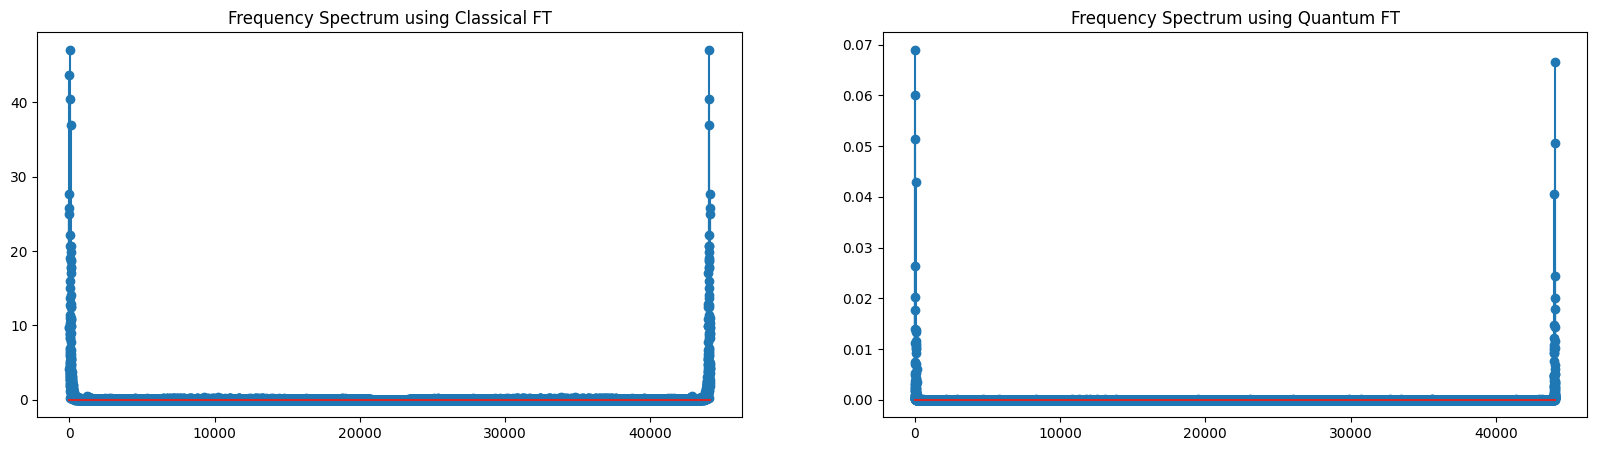

In [25]:
#Comparing Fourier spectrum from both
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.stem(freq,np.abs(fft))
plt.title('Frequency Spectrum using Classical FT')

plt.subplot(1,2,2)
plt.stem(freq,qft)
plt.title('Frequency Spectrum using Quantum FT')

plt.subplots_adjust(wspace=0.2)

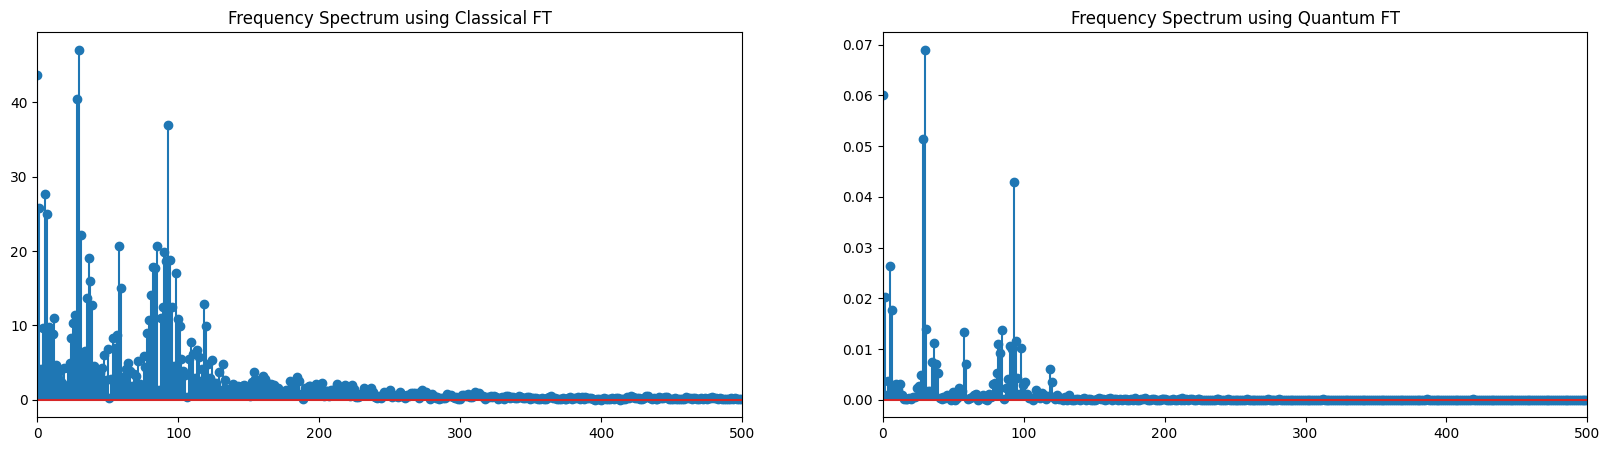

In [35]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.stem(freq,np.abs(fft))
plt.title('Frequency Spectrum using Classical FT')
plt.xlim(0,500)

plt.subplot(1,2,2)
plt.stem(freq,qft)
plt.title('Frequency Spectrum using Quantum FT')
plt.xlim(0,500)

plt.subplots_adjust(wspace=0.2)

In [27]:
#Finding the top 5 frequencies from both
abs_fft = [np.abs(i) for i in fft]
indices_of_max_values_qft = np.argsort(qft)[-5:][::-1]
indices_of_max_values_fft = np.argsort(abs_fft)[-5:][::-1]
qft_max = [freq[i] for i in indices_of_max_values_qft]
fft_max = [freq[i] for i in indices_of_max_values_fft]
print('Max 5 frequencies of the audio obtained using the Quantum FT is',qft_max)
print('Max 5 frequencies of the audio obtained using the Classical FT is',fft_max)

Max 5 frequencies of the audio obtained using the Quantum FT is [29.608154296875, 44070.391845703125, 0.0, 28.2623291015625, 44071.73767089844]
Max 5 frequencies of the audio obtained using the Classical FT is [29.608154296875, 44070.391845703125, 0.0, 44071.73767089844, 28.2623291015625]


In [28]:
#Calculating power spectrum
power_spectrum_classical = [np.abs(i)**2 for i in fft]

total_power_classical = np.sum(power_spectrum_classical)
total_power_quantum = np.sum(qft)*len(data)
print('Total power of the audio obtained using the Quantum FT is',total_power_quantum)
print('Total power of the audio obtained using the Classical FT is',total_power_classical)

Total power of the audio obtained using the Quantum FT is 32767.999999999993
Total power of the audio obtained using the Classical FT is 32767.999999999996
